## Data analysis

In [1]:
from l_p2 import persistence_length
import matplotlib.pyplot as plt
import numpy as np
import scipy
import MDAnalysis as mda
from MDAnalysis.analysis import polymer
import glob
import pandas as pd
from scipy.stats import linregress
import os
from polymer_dictionary import polymer_dictionary
from pl_com import persistence_length1

ref_length = 0.3563594872561357

/home/jbieri/miniforge3/envs/p_l/lib/python3.11/site-packages/foyer/forcefield.py:34: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import iter_entry_points, resource_filename
/home/jbieri/miniforge3/envs/p_l/lib/python3.11/site-packages/pkg_resources/__init__.py:3146: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)



Support for writing out LAMMPS data files will be removed
in mbuild 1.0.
See GMSO (https://github.com/mosdef-hub/gmso/tree/main/gmso/formats/lammpsdata) for
continued support for LAMMPS.



In [2]:
# Getting a sorted list of the 10mer trajectories
key_list = sorted(list(polymer_dictionary.keys())) # Aligning dictionary and path to aid automation
path = os.getcwd() # Non-user specific path
molecule_list = sorted(glob.glob(path+"/gsd_files/10_mers/"+"*_10mer.gsd"))
p_lens = []

In [3]:
h = persistence_length(filepath=molecule_list[0],
                       atom_index=polymer_dictionary.get(key_list[0]).get("Sulfur index"),
                       monomer_count=10,
                       start=1)
l_p = h[0]
l_b = h[1]
x_values = h[2]
C_n = h[3]
exp_fit = h[4]
decorr = h[-2]
# p_lens.append(l_p*ref_length*10)

In [4]:
print(l_p*ref_length*10)

77.88616651083395


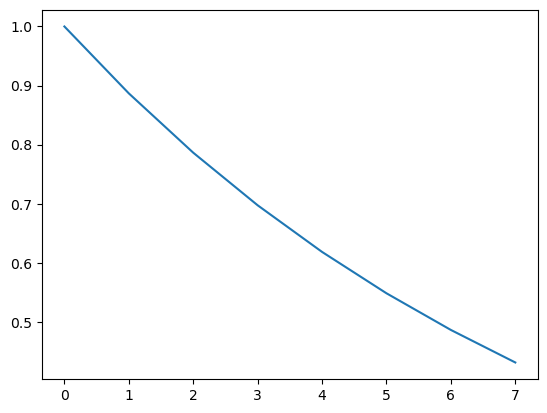

In [9]:
plt.plot(exp_fit)

### Calculating persistence lengths:

In [3]:
p_lens = []
for i in range(len(molecule_list)):
    h = persistence_length(filepath=molecule_list[i],
                       atom_index=polymer_dictionary.get(key_list[i]).get("Sulfur index"),
                       monomer_count=10,
                       start=40)
    l_p = h[0]
    l_b = h[1]
    x_values = h[2]
    C_n = h[3]
    exp_fit = h[4]
    decorr = h[-2]
    p_lens.append(l_p*ref_length*10)

persistence length: 170.00003323549205 ang


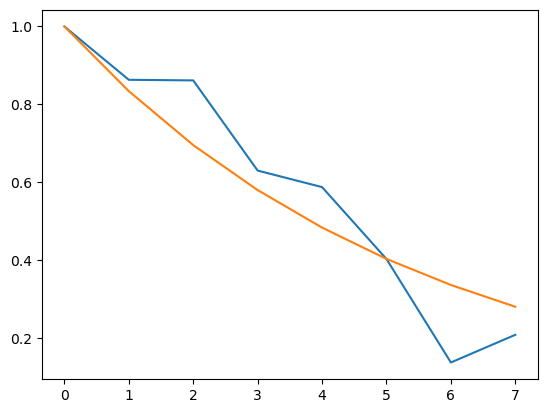

In [6]:
print('persistence length:',l_p*ref_length*10, 'ang')
plt.plot(C_n)
plt.plot(exp_fit)

## Comparison against Danielsen et al. paper

In [4]:
measured_pl = [291, 67.0, 78.4, 86.4, 114, 47.3, 54.9, 83.4, 61.0, 76.6, 1310, 236, 254] # Measured persistence length using SANS (in alphabetical order)

In [5]:
differences = np.array(measured_pl) - np.array(p_lens)

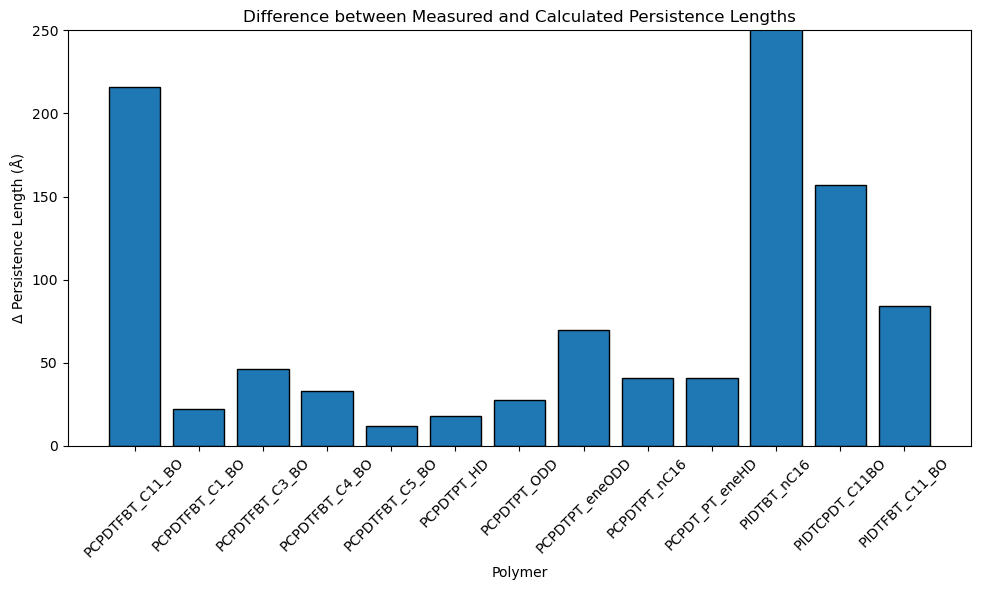

In [6]:
plt.figure(figsize=(10, 6))
plt.bar(key_list[0:len(molecule_list)], differences, edgecolor='black')

plt.xlabel('Polymer')
plt.ylabel('Δ Persistence Length (Å)')
plt.title('Difference between Measured and Calculated Persistence Lengths')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(0,250)
plt.show()

In [10]:
data = {"Polymer": key_list[0:len(molecule_list)], "Persistence length (Å)": p_lens, "Measured length (Å)": measured_pl}
df = pd.DataFrame(data)

In [11]:
print(df)

            Polymer  Persistence length (Å)  Measured length (Å)
0   PCPDTFBT_C11_BO               75.197854                291.0
1    PCPDTFBT_C1_BO               45.039604                 67.0
2    PCPDTFBT_C3_BO               32.070277                 78.4
3    PCPDTFBT_C4_BO               53.085646                 86.4
4    PCPDTFBT_C5_BO              102.136501                114.0
5        PCPDTPT_HD               29.250936                 47.3
6       PCPDTPT_ODD               27.378094                 54.9
7    PCPDTPT_eneODD               13.558707                 83.4
8      PCPDTPT_nC16               19.940731                 61.0
9    PCPDT_PT_eneHD               35.598622                 76.6
10      PIDTBT_nC16               36.503934               1310.0
11   PIDTCPDT_C11BO               78.800478                236.0
12   PIDTFBT_C11_BO              170.000033                254.0


In [29]:
l_p, l_b, x, auto_avg, fit, exp_coeff, acorr, decor, unit_bonds = persistence_length(
    filepath="PCPDTFBT_C4_BO_10mer_linear_test.gsd", 
    atom_index=28,        
    monomer_count=10
)

<Atom 29: S2 of type S2 of resname 0, resid 0 and segid SYSTEM>
<Atom 131: S2 of type S2 of resname 0, resid 0 and segid SYSTEM>
<Atom 233: S2 of type S2 of resname 0, resid 0 and segid SYSTEM>
<Atom 335: S2 of type S2 of resname 0, resid 0 and segid SYSTEM>
<Atom 437: S2 of type S2 of resname 0, resid 0 and segid SYSTEM>
<Atom 539: S2 of type S2 of resname 0, resid 0 and segid SYSTEM>
<Atom 641: S2 of type S2 of resname 0, resid 0 and segid SYSTEM>
<Atom 743: S2 of type S2 of resname 0, resid 0 and segid SYSTEM>
<Atom 845: S2 of type S2 of resname 0, resid 0 and segid SYSTEM>
<Atom 947: S2 of type S2 of resname 0, resid 0 and segid SYSTEM>


In [30]:
print(l_p*ref_length*10)

15985111.828594675


In [37]:
pl_cm = l_p*ref_length*10

In [38]:
print(str(pl_cm * 10 **-8)+" cm")

0.15985111828594675 cm


## Using center of mass of a monomer as input 

In [13]:
p_lens = []
for i in range(len(molecule_list)):
    h = persistence_length1(filepath=molecule_list[i],
                       monomer_count=10,
                       start=40)
    l_p = h[0]
    l_b = h[1]
    x_values = h[2]
    C_n = h[3]
    exp_fit = h[4]
    decorr = h[-2]
    p_lens.append(l_p*ref_length*10)

data = {"Polymer": key_list[0:len(molecule_list)], "Persistence length (Å)": p_lens, "Measured length (Å)": measured_pl}
df = pd.DataFrame(data)
print(df)

            Polymer  Persistence length (Å)  Measured length (Å)
0   PCPDTFBT_C11_BO               65.368262                291.0
1    PCPDTFBT_C1_BO               36.415806                 67.0
2    PCPDTFBT_C3_BO               11.251067                 78.4
3    PCPDTFBT_C4_BO               55.531983                 86.4
4    PCPDTFBT_C5_BO              213.120244                114.0
5        PCPDTPT_HD               11.509614                 47.3
6       PCPDTPT_ODD               43.081198                 54.9
7    PCPDTPT_eneODD               15.910177                 83.4
8      PCPDTPT_nC16               11.525078                 61.0
9    PCPDT_PT_eneHD               48.474298                 76.6
10      PIDTBT_nC16               96.927327               1310.0
11   PIDTCPDT_C11BO              254.598532                236.0
12   PIDTFBT_C11_BO              252.849709                254.0


## Calculating real temperatures based on 

In [40]:
kb = 1.3806*10**-23
epsilons = [1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046, 1.046]
temperatures = [252, 503, 1006]
t252 = []
t503 = []
t1006 = []
T = []
for temp in temperatures:
    for i in epsilons:
        T.append((temp*kb)/1.046)

In [38]:
t252 = (T[0:int(len(T)/3)])
t503 = (T[int(len(T)/3):2*int(len(T)/3)])
t1006 = (T[2*int(len(T)/3):])